- Set up [anaconda with python 3.7](https://www.anaconda.com/distribution/#download-section). **If you already have it installed** but you don't want to change the versions of your modules etc, you can make a new conda environment, with: ``conda create --name py37 python=3.7`` then activate it with ``source activate py37``.
    
- Next install [GPFlow](https://github.com/GPflow/GPflow). To do this we install from their development branch which can deal with the new Tensorflow:

        pip install git+https://github.com/GPflow/GPflow.git@develop#egg=gpflow
        
- "This will automatically install all required dependencies. (Note: as of January 2020, PyPI only has tensorflow 2.x for python 3.6 and 3.7, not for python 3.8, which is the latest release and the Anaconda default.)"
- I found that because I had an older version of tensorflow this broke, and I had to install the new version of tensorflow. And also run pip install --upgrade multipledispatch

Then based on the [notebook](https://github.com/GPflow/docs/blob/master/doc/source/notebooks/basics/regression.ipynb) provided by James.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
%matplotlib inline

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [163]:
X = 4+4*np.random.rand(20)[:,None]
Y = 1+np.cos(X)+0.1*np.random.randn(X.shape[0])[:,None]
k = gpflow.kernels.Matern52()
Y = Y - np.mean(Y)
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

##We can set the parameters manually
#m.likelihood.variance.assign(0.01)
#m.kernel.lengthscales.assign(0.3)

##Or use maximum likelihood optimisation
opt = gpflow.optimizers.Scipy()
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))

In [164]:
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.120707  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.8165    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0163614 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

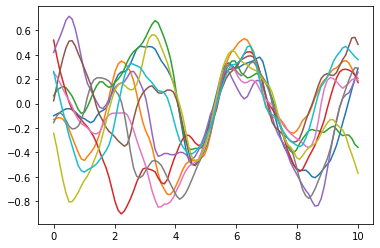

In [165]:
plt.plot(testX,m.predict_f_samples(testX,10)[:,:,0].numpy().T)

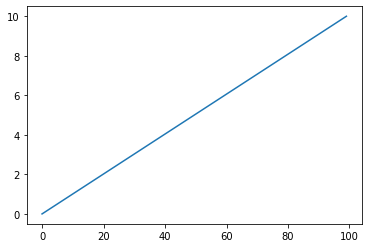

In [166]:
plt.plot(testX,)

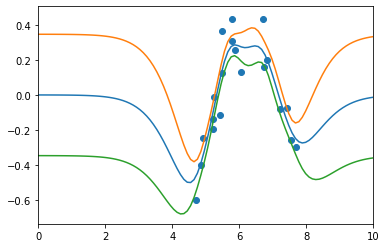

In [167]:
testX = np.linspace(0,10,100)[:,None]
testmeans, testvars = m.predict_f(testX)
plt.scatter(X,Y)
plt.xlim([0,10])
#plt.ylim([0,2])
plt.plot(testX,testmeans)
plt.plot(testX,testmeans+np.sqrt(testvars))
plt.plot(testX,testmeans-np.sqrt(testvars))

# Get Sensor Data

We need to install google-cloud-bigquery:

        pip install google-cloud-bigquery
        
Then using Dennis' code:

In [16]:
import pandas as pd
from google.cloud import bigquery
import numpy as np

In [17]:
client = bigquery.Client.from_service_account_json("/home/mike/.gcp_keys/AirQo-519978d8cadc.json")

In [18]:
def get_static_channels():
    sql = """
        SELECT channel_id 
        FROM `airqo-250220.thingspeak.channel` 
        WHERE NOT LOWER(name) LIKE '%mobile%' 
        LIMIT 1000
    """
    channels = [channel.channel_id for channel in client.query(sql).result()]
    return channels

channels = get_static_channels()
channels[0:5]



def get_df(channel_id):
    sql = """
    SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    return df

def get_loc(channel_id):
    sql = """
    SELECT channel_id, longitude, latitude 
    FROM `airqo-250220.thingspeak.channel`
    WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    
    return df


In [42]:
def get_entries_since(channel_id,daysago=7):
    from datetime import datetime,timedelta
    datestring = (datetime.now()-timedelta(daysago)).strftime("%Y-%m-%d %H:%M:%S") # current date and time

    sql = """
    SELECT created_at, channel_id, pm2_5 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    AND created_at > '{}'
    """.format(channel_id,datestring)

    df = client.query(sql).to_dataframe() 
    
    return df

X = []
Y = []
for chan in channels:
    print(chan)
    d = get_entries_since(chan)
    loc = get_loc(chan)
    X.append(np.array(loc)[:,1:])
    Y.append(np.mean(d['pm2_5']))
#X = np.c_[np.repeat(np.array(loc)[:,1:],d.shape[0],0),[n.timestamp()/3600 for n in d['created_at']]]
#X[:,-1]-=np.min(X[:,-1])

930426
912220
912223
912222
930427
912219
912224
912221
912225
782723
741341
870143
870142
870147
870145
870144
755609
718030
689520
689749
672528
870139
832253
755614
689756
689516
643696
675991
730014
782721
676000
689518
832255
689753
782719
832251
689525
718029
832254
870140
675851
870146
832252
675805
718028
737273
730019
689750
737278
730016
737276
742703
675801


KeyboardInterrupt: 

In [43]:
Xtraining = np.array(X)[:,0,:]

In [45]:
Ytraining = np.array(Y)[:,None]

In [48]:
Xtraining #NxDimensions

array([[32.6468  ,  0.3655  ],
       [32.576   ,  0.322108],
       [32.635306,  0.341674],
       [32.632288,  0.325346],
       [32.588   ,  0.2689  ],
       [32.62583 ,  0.391478],
       [32.70328 ,  0.34646 ],
       [32.5757  ,  0.32232 ],
       [32.506107,  0.286595],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [32.6471  ,  0.3816  ],
       [32.528   ,  0.3759  ],
       [32.529   ,  0.363   ],
       [32.6282  ,  0.3731  ],
       [32.6516  ,  0.307   ],
       [29.9892  , -1.245   ],
       [32.6494  ,  0.347   ],
       [34.3724  ,  1.332   ],
       [33.6212  ,  1.7145  ],
       [30.1069  , -0.2651  ],
       [32.516   ,  0.3101  ],
       [32.558   ,  0.27    ],
       [32.602   ,  0.3412  ],
       [33.47    ,  0.6114  ],
       [34.1617  ,  1.0761  ],
       [ 0.      ,  0.      ],
       [30.0837  ,  0.178   ],
       [32.5576  ,  0.2357  ],
       [32.5635  ,  0.2336  ],
       [30.2676  ,  0.6576  ],
       [34.0949  ,  0.4658  ],
       [

In [55]:
keep = ~np.isnan(Ytraining[:,0])
Ytraining = Ytraining[keep,:]
Xtraining = Xtraining[keep,:]

In [245]:
Xtraining

array([[32.6468  ,  0.3655  ],
       [32.576   ,  0.322108],
       [32.635306,  0.341674],
       [32.632288,  0.325346],
       [32.588   ,  0.2689  ],
       [32.70328 ,  0.34646 ],
       [32.5757  ,  0.32232 ],
       [32.506107,  0.286595],
       [32.6471  ,  0.3816  ],
       [32.528   ,  0.3759  ],
       [32.529   ,  0.363   ],
       [32.6282  ,  0.3731  ],
       [32.6516  ,  0.307   ],
       [29.9892  , -1.245   ],
       [32.6494  ,  0.347   ],
       [34.3724  ,  1.332   ],
       [33.6212  ,  1.7145  ],
       [30.1069  , -0.2651  ],
       [32.516   ,  0.3101  ],
       [32.602   ,  0.3412  ],
       [33.47    ,  0.6114  ],
       [34.1617  ,  1.0761  ],
       [30.0837  ,  0.178   ],
       [32.5576  ,  0.2357  ],
       [32.5635  ,  0.2336  ],
       [34.0949  ,  0.4658  ],
       [33.21    ,  0.433   ],
       [32.615   ,  0.2988  ],
       [32.592   ,  0.299   ],
       [34.3312  ,  1.0112  ],
       [32.4603  ,  0.0596  ],
       [31.7612  , -0.3213  ],
       [

In [225]:
m.kernel.kernels[0].lengthscales

<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=-6.9072552373154705 constrained-shape=() constrained-value=0.001000000000000043>

In [235]:
k = gpflow.kernels.RBF() + gpflow.kernels.Bias()
#Ytraining = Ytraining - np.mean(Ytraining)
m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
m.kernel.kernels[0].lengthscales.assign(0.01) #~300m ->
m.kernel.kernels[0].variance.assign(10000)
m.likelihood.variance.assign(0.1)
from gpflow import set_trainable
set_trainable(m.kernel.kernels[0].lengthscales, False) #thanks Pablo!!!! YAY

opt = gpflow.optimizers.Scipy()
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))

#m.kernel.lengthscales.assign(0.005) 

In [236]:
m.trainable_parameters

(<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=214.96018450046114 constrained-shape=() constrained-value=214.96018450046114>,
 <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=1201.8702114296473 constrained-shape=() constrained-value=1201.8702114296473>,
 <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=-3825.764738955374 constrained-shape=() constrained-value=1e-06>)

In [237]:
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  214.96  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │    0.01  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1201.87  │


In [238]:
Ytraining

array([[32.68945727],
       [25.90385371],
       [29.14582286],
       [25.79888809],
       [33.96908352],
       [30.93584404],
       [26.29018843],
       [35.13388781],
       [35.33456181],
       [43.76623581],
       [70.68943437],
       [28.98670058],
       [29.83198164],
       [37.20158296],
       [45.47086957],
       [22.24724145],
       [32.08999666],
       [46.49495866],
       [49.5174185 ],
       [12.14789037],
       [34.54766615],
       [45.77872941],
       [35.93928467],
       [41.61144279],
       [14.84571504],
       [22.85808955],
       [21.33512457],
       [17.68378493],
       [27.54186455],
       [54.83320044],
       [17.2973675 ],
       [47.74107805],
       [15.66865842],
       [18.67185114],
       [30.67058719],
       [40.06738251],
       [29.98982282],
       [59.25193137],
       [60.44029441],
       [41.41805059]])

In [239]:
Xtest = np.meshgrid(np.linspace(32.4,32.8,150),np.linspace(0.1,0.5,150))

In [240]:
Xtestflat = np.c_[Xtest[0].flatten(),Xtest[1].flatten()]
predmeans,predvars = m.predict_f(Xtestflat)

In [249]:
Xdemotest = np.array([[32,0.1,10223434],[32,0.1,10223435],[32,0.1,10223436],[32,0.1,10223437]])
Xdemotest

array([[3.2000000e+01, 1.0000000e-01, 1.0223434e+07],
       [3.2000000e+01, 1.0000000e-01, 1.0223435e+07],
       [3.2000000e+01, 1.0000000e-01, 1.0223436e+07],
       [3.2000000e+01, 1.0000000e-01, 1.0223437e+07]])

In [241]:
predmeans

<tf.Tensor: shape=(22500, 1), dtype=float64, numpy=
array([[34.60530067],
       [34.60530067],
       [34.60530066],
       ...,
       [34.60530067],
       [34.60530067],
       [34.60530067]])>

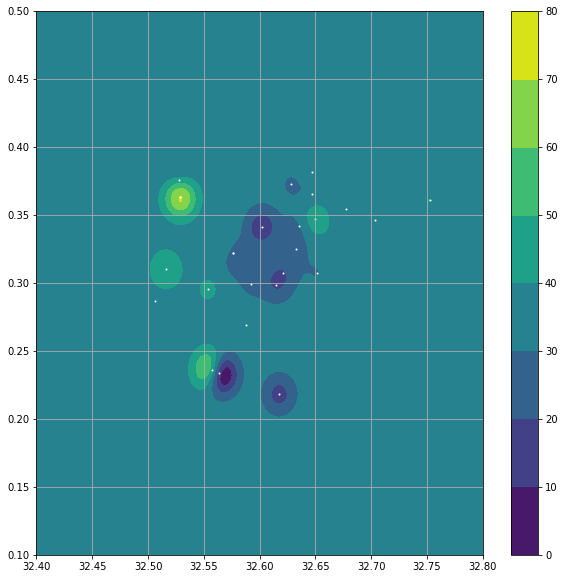

In [242]:
plt.figure(figsize=[10,10])

plt.xlim([32.4,32.8])
plt.ylim([0.1,0.5])
plt.contourf(Xtest[0],Xtest[1],predmeans.numpy().reshape([150,150]))
plt.colorbar()
plt.scatter(Xtraining[:,0],Xtraining[:,1],1,color='w')
plt.grid()

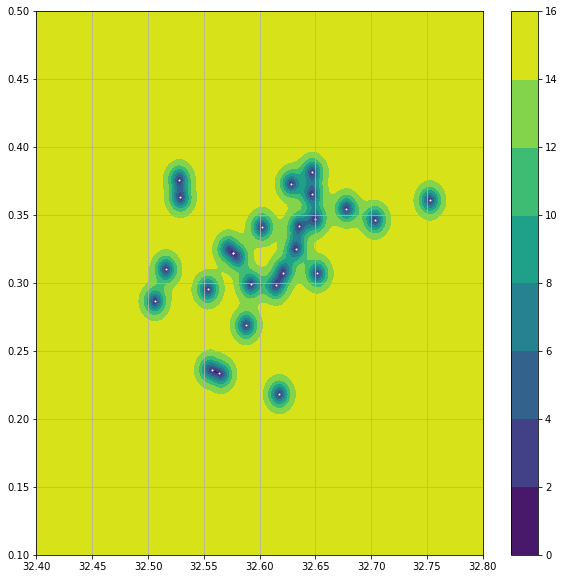

In [243]:
plt.figure(figsize=[10,10])

plt.xlim([32.4,32.8])
plt.ylim([0.1,0.5])
plt.contourf(Xtest[0],Xtest[1],np.sqrt(predvars.numpy()).reshape([150,150]))
plt.colorbar()
plt.scatter(Xtraining[:,0],Xtraining[:,1],1,color='w')
plt.grid()



In [244]:
Y

array([[ 0.13246976],
       [-0.07843729],
       [-0.11641632],
       [-0.24473446],
       [ 0.16168916],
       [ 0.30835531],
       [-0.07397372],
       [ 0.43665464],
       [-0.29738946],
       [-0.60049312],
       [-0.14017718],
       [ 0.3643612 ],
       [-0.25993824],
       [-0.39887106],
       [ 0.19999607],
       [-0.01244986],
       [ 0.12570447],
       [ 0.4352857 ],
       [ 0.25448698],
       [-0.19612262]])

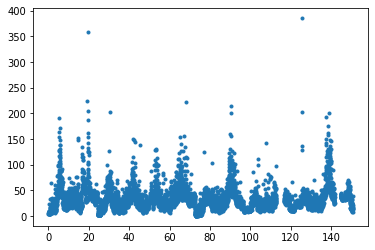

In [123]:
plt.plot(X[:,-1],Y,'.')

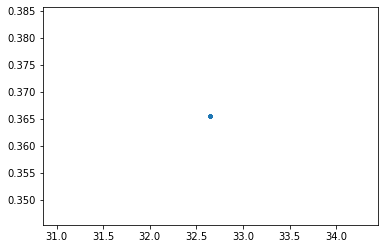

In [27]:
plt.plot(X[:,0],X[:,1],'.')